In [140]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
import torchvision
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
import pandas as pd
import os

In [141]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [142]:
batch_size = 32

# Transformaciones
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Cargar datasets
train_dataset = torchvision.datasets.ImageFolder(
    root='kaggle/seg_train/seg_train',
    transform=train_transform
)

test_dataset = torchvision.datasets.ImageFolder(
    root='kaggle/seg_test/seg_test',
    transform=test_transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [143]:
# Crear modelo
input_size = 32 * 32 * 3
n_classes = len(train_dataset.classes)

model = nn.Sequential(
    nn.Flatten(),

    nn.Linear(input_size, 1024),
    nn.BatchNorm1d(1024),
    nn.GELU(),
    nn.Dropout(0.3),

    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.GELU(),
    nn.Dropout(0.3),

    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.GELU(),
    nn.Dropout(0.3),

    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.GELU(),
    nn.Dropout(0.2),

    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.GELU(),
    nn.Dropout(0.2),

    nn.Linear(64, n_classes)
)

model = model.to(device)
print(model)
print(f"\nParámetros: {sum(p.numel() for p in model.parameters()):,}")

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=1024, bias=True)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): GELU(approximate='none')
  (4): Dropout(p=0.3, inplace=False)
  (5): Linear(in_features=1024, out_features=512, bias=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): GELU(approximate='none')
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=512, out_features=256, bias=True)
  (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): GELU(approximate='none')
  (12): Dropout(p=0.3, inplace=False)
  (13): Linear(in_features=256, out_features=128, bias=True)
  (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): GELU(approximate='none')
  (16): Dropout(p=0.2, inplace=False)
  (17): Linear(in_features=128, out_features=64, bias=True)
  (18): B

In [144]:
# Loss y optimizer
loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = Adam(model.parameters(), lr=0.001)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=2,
    factor=0.5
)

In [145]:
def train():
    total_loss = 0
    correct = 0
    total = 0

    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        output = model(x)
        batch_loss = loss_function(output, y)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item()
        preds = output.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total

    print(f'Train - Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}')
    return epoch_loss, epoch_acc

In [146]:
def validate():
    total_loss = 0
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            output = model(x)
            batch_loss = loss_function(output, y)

            total_loss += batch_loss.item()
            preds = output.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    epoch_loss = total_loss / len(test_loader)
    epoch_acc = correct / total

    print(f'Valid - Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}')
    return epoch_loss, epoch_acc

In [148]:
epochs = 25
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    
    train_loss, train_acc = train()
    val_loss, val_acc = validate()

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print()

Epoch: 0
Train - Loss: 1.3029 Accuracy: 0.5591
Valid - Loss: 1.2404 Accuracy: 0.5810

Epoch: 1
Train - Loss: 1.2718 Accuracy: 0.5752
Valid - Loss: 1.2020 Accuracy: 0.6100

Epoch: 2
Train - Loss: 1.2455 Accuracy: 0.5894
Valid - Loss: 1.1819 Accuracy: 0.6163

Epoch: 3
Train - Loss: 1.2187 Accuracy: 0.6058
Valid - Loss: 1.1760 Accuracy: 0.6107

Epoch: 4
Train - Loss: 1.2016 Accuracy: 0.6150
Valid - Loss: 1.1647 Accuracy: 0.6280

Epoch: 5
Train - Loss: 1.1786 Accuracy: 0.6275
Valid - Loss: 1.1515 Accuracy: 0.6460

Epoch: 6
Train - Loss: 1.1798 Accuracy: 0.6263
Valid - Loss: 1.1584 Accuracy: 0.6267

Epoch: 7
Train - Loss: 1.1695 Accuracy: 0.6332
Valid - Loss: 1.1308 Accuracy: 0.6433

Epoch: 8
Train - Loss: 1.1555 Accuracy: 0.6383
Valid - Loss: 1.1248 Accuracy: 0.6487

Epoch: 9
Train - Loss: 1.1483 Accuracy: 0.6414
Valid - Loss: 1.1330 Accuracy: 0.6467

Epoch: 10
Train - Loss: 1.1422 Accuracy: 0.6459
Valid - Loss: 1.1107 Accuracy: 0.6567

Epoch: 11
Train - Loss: 1.1269 Accuracy: 0.6532
Valid

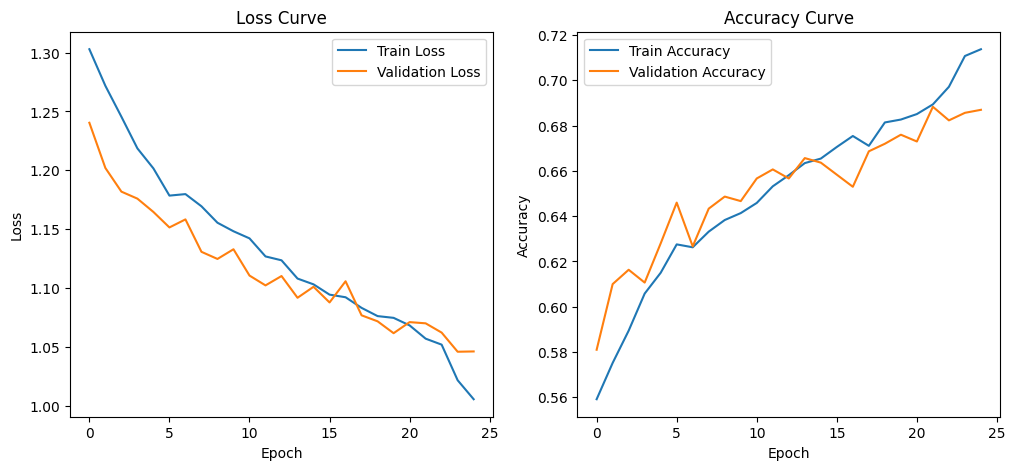

In [149]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()